<a href="https://www.kaggle.com/code/firlanaumi/cnn-mnist-pytorch?scriptVersionId=241881358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import os
import struct
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt


### 📦 Import Library dan Modul
Pada cell ini, kita mengimpor berbagai library penting untuk proyek deep learning menggunakan PyTorch:

- `torch`, `torch.nn`, dan `torch.nn.functional`: digunakan untuk membangun dan menjalankan arsitektur model neural network.
- `torch.optim`: menyediakan berbagai algoritma optimasi seperti Adam, SGD, dll.
- `torchvision`: untuk mengakses dataset populer dan melakukan transformasi pada data.
- `os` dan `struct`: membantu membaca file dataset dalam format `.idx` (biner).
- `numpy`: manipulasi array numerik.
- `tqdm`: memberikan tampilan progress bar saat training atau testing.
- `matplotlib.pyplot`: digunakan untuk membuat grafik performa model seperti loss dan akurasi.

Library-library ini menjadi dasar untuk proses pelatihan, evaluasi, dan visualisasi model machine learning.


In [ ]:
def read_idx(filename):
    """Read IDX file format"""
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

### 📂 Fungsi Pembaca Dataset: `read_idx()`
Fungsi `read_idx()` digunakan untuk membaca file dataset dalam format `.idx`, format biner standar yang biasa digunakan oleh dataset seperti MNIST atau Fashion-MNIST.

### 🔍 Penjelasan Detail:
- `with open(filename, 'rb') as f`: membuka file dalam mode baca biner (`rb`).
- `struct.unpack('>HBB', f.read(4))`: membaca 4 byte pertama dari file untuk mengetahui:
  - `zero`: byte kosong awal (biasanya nol),
  - `data_type`: tipe data yang digunakan,
  - `dims`: jumlah dimensi array (misalnya, 3 untuk data gambar: jumlah gambar, tinggi, lebar).
- `shape = ...`: membaca ukuran tiap dimensi (misalnya 60000x28x28).
- `np.frombuffer(...)`: membaca seluruh isi file dan mengonversinya menjadi array NumPy bertipe `uint8`.
- `.reshape(shape)`: membentuk ulang array sesuai dimensi aslinya agar siap digunakan sebagai input model.

Fungsi ini esensial untuk menyiapkan data sebelum digunakan dalam proses training model.


# Load Dataset

In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32)
        image = image / 255.0
        image = image.unsqueeze(0)  # (1, 28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label


### 🧩 Kelas Custom Dataset: `CustomMNISTDataset`
Kelas ini digunakan untuk membungkus dataset MNIST agar bisa digunakan dengan PyTorch `DataLoader`.

### 🔍 Penjelasan Fungsi:
- `__init__`: Konstruktor yang menerima array `images`, `labels`, dan `transform` (opsional).
- `__len__`: Mengembalikan jumlah total data (jumlah gambar).
- `__getitem__`: Mengambil satu gambar dan label berdasarkan indeks (`idx`) lalu:
  - Mengubah gambar menjadi tensor float (`torch.float32`),
  - Menormalisasi ke skala 0-1 dengan membagi 255,
  - Menambahkan dimensi channel agar formatnya `[1, 28, 28]` (karena MNIST adalah grayscale),
  - Menerapkan transformasi jika disediakan (`self.transform`).

✅ Fungsionalitas ini sangat penting agar dataset bisa digunakan dalam training PyTorch seperti `DataLoader(train_dataset, ...)`.


In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomCrop(28, padding=4),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

### 🎛️ Data Augmentation dan Normalisasi

Transformasi ini digunakan untuk mempersiapkan data agar lebih sesuai dengan kebutuhan model:

#### 🏋️‍♀️ `train_transform`:
- `RandomRotation(15)`: Memutar gambar secara acak hingga 15 derajat, untuk meningkatkan keragaman data.
- `RandomCrop(28, padding=4)`: Memotong gambar secara acak dengan padding, agar model lebih robust terhadap pergeseran posisi objek.
- `Normalize((0.5,), (0.5,))`: Menormalkan gambar agar mean = 0 dan std = 1.  
  Karena MNIST grayscale, hanya pakai satu nilai mean dan std (`(0.5,)`).

#### 🧪 `test_transform`:
- Hanya melakukan normalisasi, tanpa augmentasi. Ini karena data uji harus mencerminkan data sebenarnya tanpa distorsi tambahan.

🎯 Tujuan dari transformasi ini adalah membuat model lebih **general** dan tidak overfitting pada data training.


In [5]:
data_dir = '/kaggle/input/mnist-dataset'

train_images = read_idx(os.path.join(data_dir, 'train-images.idx3-ubyte'))
train_labels = read_idx(os.path.join(data_dir, 'train-labels.idx1-ubyte'))

test_images = read_idx(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
test_labels = read_idx(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))

print(f"Train images shape: {train_images.shape}")  # (60000, 28, 28)
print(f"Train labels shape: {train_labels.shape}")  # (60000,)

print(f"Test images shape: {test_images.shape}")  # (10000, 28, 28)
print(f"Test labels shape: {test_labels.shape}")  # (10000,)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


## Membaca Dataset MNIST
Kode ini membaca file gambar dan label dari dataset MNIST dalam format IDX yang disimpan secara lokal:

- `train_images` dan `train_labels` merepresentasikan gambar dan label dari data latih.
- `test_images` dan `test_labels` merepresentasikan gambar dan label dari data uji.
- Fungsi `read_idx()` digunakan untuk memuat file IDX dan mengubahnya menjadi array NumPy dengan bentuk:
  - `train_images.shape`: (60000, 28, 28) → 60.000 gambar berukuran 28x28 piksel.
  - `train_labels.shape`: (60000,) → 60.000 label yang sesuai dengan gambar latih.
  - `test_images.shape`: (10000, 28, 28) → 10.000 gambar uji.
  - `test_labels.shape`: (10000,) → 10.000 label uji.

Output ini memastikan bahwa dataset berhasil dimuat sebelum melanjutkan ke proses training dan evaluasi.


# Augmentation samples

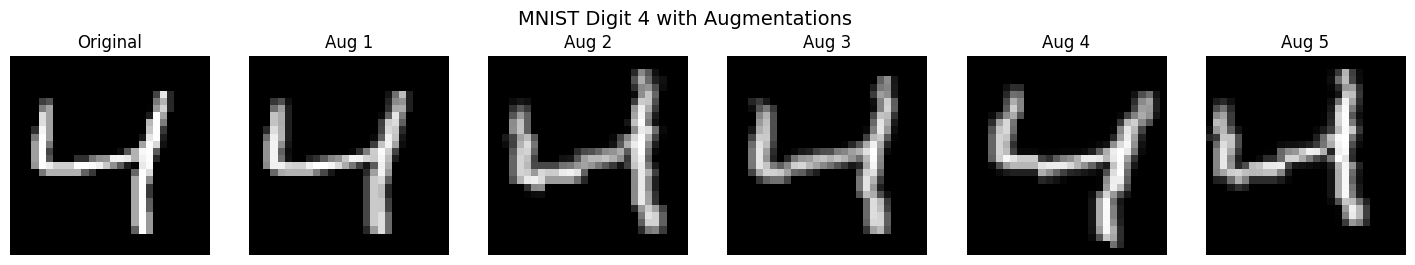

In [6]:
from PIL import Image

augment_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])


sample_idx = 2
image_np = train_images[sample_idx]  # shape: (28, 28)
label = train_labels[sample_idx]

image_pil = Image.fromarray(image_np)

fig, axs = plt.subplots(1, 6, figsize=(18, 3))
axs[0].imshow(image_pil, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

# Apply and show augmentations
for i in range(5):
    aug_img = augment_transform(image_pil)
    axs[i+1].imshow(aug_img.squeeze(0), cmap='gray')
    axs[i+1].set_title(f'Aug {i+1}')
    axs[i+1].axis('off')

plt.suptitle(f'MNIST Digit {label} with Augmentations', fontsize=14)
plt.show()

## Visualisasi dan Augmentasi Data MNIST
Kode ini melakukan augmentasi (peningkatan variasi data) terhadap satu gambar angka dari dataset MNIST:

- `augment_transform` berisi transformasi data seperti:
  - `RandomRotation(15)` → Memutar gambar secara acak hingga ±15 derajat.
  - `RandomResizedCrop(28, scale=(0.8, 1.0), ratio=(0.9, 1.1))` → Memotong dan mengubah ukuran gambar dengan rasio dan skala acak.
  - `ToTensor()` → Mengubah gambar PIL menjadi tensor PyTorch.

Satu gambar dari dataset (pada indeks ke-2, yaitu angka 4) dipilih sebagai contoh. Gambar ini ditampilkan di sisi kiri, lalu lima versi hasil augmentasi dari gambar tersebut ditampilkan di sampingnya. Setiap augmentasi dilakukan secara acak untuk menunjukkan variasi bentuk dari angka yang sama.

Tujuan dari augmentasi ini adalah untuk:
- Meningkatkan variasi data pelatihan.
- Membantu model belajar mengenali bentuk angka dalam kondisi yang berbeda (seperti miring, dipotong, dll).
- Mengurangi overfitting dan meningkatkan kemampuan generalisasi model.

Visualisasi ini sangat berguna untuk memastikan bahwa proses augmentasi bekerja dengan baik sebelum digunakan dalam pelatihan model.
ola.


In [7]:
train_dataset = CustomMNISTDataset(train_images, train_labels, transform=train_transform)
test_dataset = CustomMNISTDataset(test_images, test_labels, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### 🔧 Membuat Dataset Kustom dan DataLoader
Kode ini bertujuan untuk membungkus data gambar dan label MNIST ke dalam CustomMNISTDataset, lalu mempermudah pengolahan data dalam mini-batch menggunakan DataLoader.

• `train_dataset` = CustomMNISTDataset(train_images, train_labels, transform=train_transform)
  → Dataset latih dengan transformasi augmentasi.

• `test_dataset` = CustomMNISTDataset(test_images, test_labels, transform=test_transform)
  → Dataset uji hanya dengan normalisasi (tanpa augmentasi).

• `train_loader` = DataLoader(train_dataset, batch_size=64, shuffle=True)
  → Data latih dibagi per batch (64 data per batch), dan diacak tiap epoch.
  
• `test_loader` = DataLoader(test_dataset, batch_size=64, shuffle=False)
  → Data uji dibagi per batch tanpa diacak urutannya.

Output ini memastikan data siap untuk digunakan dalam proses pelatihan dan evaluasi model secara efisien dan terstruktur.



# Device configuration (use GPU if available)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 🔌 Menentukan Penggunaan CPU atau GPU

• Mengecek apakah GPU (CUDA) tersedia.

• Jika tersedia, model akan menggunakan GPU (cuda) untuk mempercepat proses komputasi.

• Jika tidak tersedia, model akan menggunakan CPU.

Pemanfaatan GPU sangat penting untuk mempercepat proses training model deep learning.

# Hyperparameters

In [9]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

### 🔧 Hyperparameter Penjelasan

- `batch_size = 64`  
  Jumlah data yang diproses sekaligus dalam satu iterasi. Ukuran ini mempengaruhi kecepatan dan stabilitas training.

- `learning_rate = 0.001`  
  Menentukan seberapa besar langkah perubahan bobot setiap kali update. Nilai terlalu besar bisa tidak stabil, terlalu kecil bisa lama converge.

- `num_epochs = 10`  
  Jumlah pengulangan seluruh dataset melalui model selama proses training.


# Model CNN

In [10]:
class ModelCNN(nn.Module):
    def __init__(self):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size =5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

### 🧠 Penjelasan Arsitektur CNN (`ModelCNN`)

- `conv1`: Layer konvolusi pertama, dari 1 channel ke 6, menggunakan kernel 5x5. Padding 2 menjaga ukuran citra.
- `pool`: Layer MaxPooling untuk menurunkan resolusi (reduksi dimensi), kernel 2x2 dan stride 2.
- `conv2`: Layer konvolusi kedua, dari 6 ke 16 channel, tanpa padding.
- `fc1`: Fully connected layer dari flatten hasil konvolusi, output 120 neuron.
- `fc2`: Layer FC kedua, dari 120 ke 84 neuron.
- `fc3`: Layer akhir dengan 10 output (klasifikasi 10 digit).

Fungsi aktivasi `ReLU` digunakan di setiap layer tersembunyi untuk menambah non-linearitas.  
Data di-*flatten* sebelum masuk ke layer fully connected.


In [11]:
model = ModelCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



### ⚙️ Inisialisasi Model, Loss Function, dan Optimizer

- `ModelCNN().to(device)`  
  Membuat instance model CNN, dan memindahkannya ke device (CPU atau GPU) agar komputasi lebih cepat.

- `nn.CrossEntropyLoss()`  
  Fungsi loss untuk klasifikasi multi-kelas, cocok untuk output model berupa logits (belum softmax).

- `optim.Adam(...)`  
  Optimizer **Adam** dipilih karena adaptif dan stabil untuk berbagai jenis training.  
  `learning_rate` ditentukan dari cell hyperparameter sebelumnya.


In [12]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

100%|██████████| 938/938 [00:42<00:00, 22.29it/s]


Epoch [1/10], Loss: 0.1223


100%|██████████| 938/938 [00:40<00:00, 23.03it/s]


Epoch [2/10], Loss: 0.0516


100%|██████████| 938/938 [00:40<00:00, 23.29it/s]


Epoch [3/10], Loss: 0.3449


100%|██████████| 938/938 [00:40<00:00, 23.06it/s]


Epoch [4/10], Loss: 0.2675


100%|██████████| 938/938 [00:39<00:00, 23.47it/s]


Epoch [5/10], Loss: 0.0263


100%|██████████| 938/938 [00:39<00:00, 23.52it/s]


Epoch [6/10], Loss: 0.1378


100%|██████████| 938/938 [00:40<00:00, 23.22it/s]


Epoch [7/10], Loss: 0.1137


100%|██████████| 938/938 [00:40<00:00, 23.41it/s]


Epoch [8/10], Loss: 0.1280


100%|██████████| 938/938 [00:39<00:00, 23.56it/s]


Epoch [9/10], Loss: 0.0469


100%|██████████| 938/938 [00:40<00:00, 23.44it/s]

Epoch [10/10], Loss: 0.0157


### 🔁 Proses Training Model

- `epoch_losses = []`  
  Menyimpan rata-rata loss dari setiap epoch untuk analisis atau visualisasi nantinya.

- `for epoch in range(num_epochs):`  
  Melakukan training sebanyak `num_epochs` iterasi.

- `model.train()`  
  Mengaktifkan mode training (misalnya untuk dropout atau batchnorm).

- `tqdm(train_loader)`  
  Loader dibungkus dengan tqdm untuk menampilkan progress bar.

- `images.to(device)`  
  Memindahkan data ke device (CPU/GPU) sebelum masuk ke model.

- `loss = criterion(outputs, labels)`  
  Menghitung error antara prediksi dan label sebenarnya.

- `optimizer.zero_grad()`  
  Mengatur ulang gradien sebelum backward pass (wajib setiap iterasi).

- `loss.backward()`  
  Melakukan backpropagation untuk menghitung gradien.

- `optimizer.step()`  
  Update bobot model berdasarkan gradien.

- `total_loss += loss.item()`  
  Menjumlahkan total loss untuk dihitung rata-ratanya di akhir epoch.

- `avg_loss = total_loss / len(train_loader)`  
  Rata-rata loss untuk epoch tersebut.

- `print(...)`  
  Menampilkan nilai loss terakhir dari epoch ke layar.  
  (Seperti terlihat pada output: Loss menurun dari 0.1223 → 0.0157 menandakan training sukses.)



# Model Evaluation

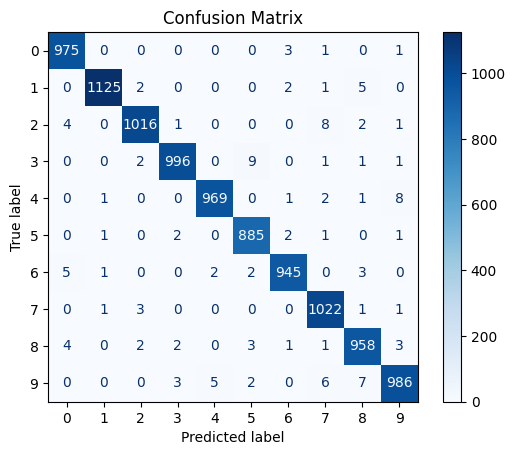

In [13]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report
)
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### 📊 Evaluasi Model dengan Confusion Matrix

- `model.eval()`  
  Mengatur model ke mode evaluasi untuk menonaktifkan dropout dan batchnorm (jika ada).

- `torch.no_grad()`  
  Menonaktifkan perhitungan gradien agar lebih efisien selama evaluasi.

- `outputs = model(images)`  
  Model menghasilkan prediksi untuk batch gambar input.

- `_, predicted = torch.max(outputs.data, 1)`  
  Mengambil kelas dengan probabilitas tertinggi dari output model.

- `y_true` dan `y_pred`  
  Dikumpulkan dari semua batch untuk menghitung keseluruhan performa model.

- `confusion_matrix(...)`  
  Menghitung jumlah prediksi benar/salah antar kelas.

- `ConfusionMatrixDisplay(...)`  
  Menampilkan visualisasi confusion matrix dengan label kelas 0–9.

- `cmap=plt.cm.Blues`  
  Warna biru digunakan untuk menunjukkan intensitas jumlah prediksi pada sel matrix.

- **Tujuan**:  
  Untuk melihat performa klasifikasi model secara mendetail per kelas, termasuk kelas mana yang paling sering salah prediksi.


## Loss result

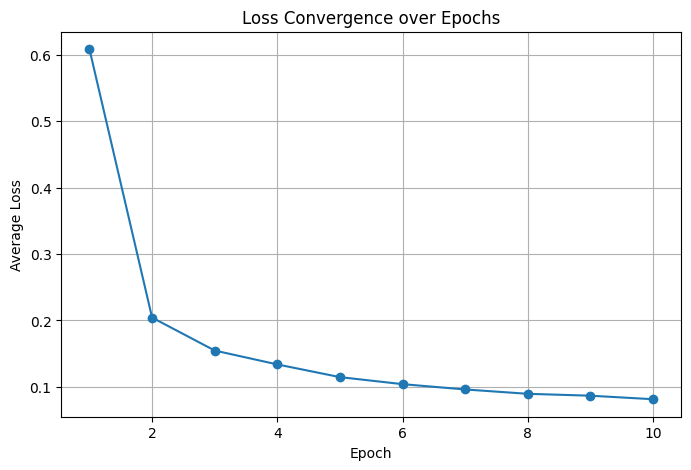

In [14]:


plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Loss Convergence over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


### 📉 Visualisasi Konvergensi Loss Selama Training

- `plt.figure(figsize=(8,5))`  
  Menentukan ukuran canvas plot agar proporsional dan mudah dibaca.

- `plt.plot(...)`  
  Membuat grafik garis loss rata-rata (`epoch_losses`) dari setiap epoch.

- `marker='o'`  
  Menandai setiap titik (epoch) dengan simbol bulat untuk memperjelas perubahan nilai loss.

- `plt.xlabel(...)` dan `plt.ylabel(...)`  
  Menambahkan label sumbu X (Epoch) dan Y (Loss).

- `plt.grid(True)`  
  Menampilkan garis bantu grid agar tren lebih mudah diikuti.

- **Tujuan**:  
  Memantau apakah model benar-benar belajar — ditunjukkan dari penurunan loss yang konsisten dari epoch ke epoch.


In [15]:
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

for i in range(len(TP)):
    print(f"Kelas {i}: FPR = {FPR[i]:.4f}, TPR (Recall) = {TPR[i]:.4f}")

Accuracy: 0.9877
Precision (macro): 0.9876
Recall (macro): 0.9877
F1-Score (macro): 0.9876

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Kelas 0: FPR = 0.0014, TPR (Recall) = 0.9949
Kelas 1: FPR = 0.0005, TPR (Recall) = 0.9912
Kelas 2: FPR = 0.0010, TPR (Recall) 

### 🧪 Evaluasi Kinerja Model secara Statistik

- `accuracy_score(y_true, y_pred)`  
  Mengukur akurasi keseluruhan model (jumlah prediksi benar dibagi total prediksi).

- `precision_score(..., average='macro')`  
  Rata-rata presisi di semua kelas (tanpa mempertimbangkan proporsi kelas).

- `recall_score(..., average='macro')`  
  Rata-rata recall (TPR) dari tiap kelas secara setara.

- `f1_score(..., average='macro')`  
  Kombinasi harmonis antara presisi dan recall untuk seluruh kelas.

- `classification_report(...)`  
  Menampilkan precision, recall, f1-score, dan support per kelas.

---

### 🔍 Menghitung TP, FP, FN, TN untuk Metrik Tambahan

- `TP`, `FP`, `FN`, `TN`  
  Diambil langsung dari confusion matrix.  
  - TP: diagonal (prediksi benar)  
  - FP: jumlah prediksi salah sebagai kelas tersebut  
  - FN: jumlah prediksi gagal mengenali kelas tersebut  
  - TN: semua prediksi lain di luar kelas

- `FPR = FP / (FP + TN)`  
  False Positive Rate: seberapa sering model salah memprediksi sebagai kelas tertentu.

- `TPR = TP / (TP + FN)`  
  True Positive Rate / Recall: seberapa baik model mengenali kelas tersebut.

- Loop per kelas (`for i in range(...)`)  
  Menampilkan nilai FPR dan TPR untuk masing-masing kelas 0–9.


# Simpan model untuk prediksi

In [16]:
torch.save(model.state_dict(), 'model_cnn_mnist.pth')
# model.load_state_dict(torch.load('cnn_mnist.pth'))

torch.save(model, 'cnn_mnist_full.pth')
# model = torch.load('cnn_mnist_full.pth')

### 💾 Menyimpan Model yang Sudah Dilatih

- `torch.save(model.state_dict(), 'model_cnn_mnist.pth')`  
  Menyimpan *state dictionary* model (parameter bobot) saja.  
  Umumnya digunakan untuk deployment ringan, model harus didefinisikan ulang sebelum loading.

- `torch.load('cnn_mnist.pth')` + `model.load_state_dict(...)`  
  Untuk memuat bobot model ke arsitektur yang sama (komentar: belum dijalankan di sini).

- `torch.save(model, 'cnn_mnist_full.pth')`  
  Menyimpan **keseluruhan model**, termasuk arsitektur dan parameter.  
  Cocok untuk pemakaian langsung tanpa redefinisi model.

- `torch.load('cnn_mnist_full.pth')`  
  Digunakan untuk load full model seperti pada model pretrained.

- 💡 **Catatan**:  
  Simpan `state_dict` untuk fleksibilitas & efisiensi. Simpan model penuh untuk kemudahan.


# Prediksi citra tulisan tangan dengan data selain data ujicoba

In [17]:
from PIL import Image

model = ModelCNN()
model.load_state_dict(torch.load('/kaggle/working/model_cnn_mnist.pth'))
model.eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((28, 28)),                  
    transforms.ToTensor(),                        
    transforms.Normalize((0.5,), (0.5,))          
])

image_path = '/kaggle/input/sampel-handwritten-number/6.jpg'  
image = Image.open(image_path)
image = transform(image)               
image = image.unsqueeze(0)             

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)

print(f'Predicted Class: {predicted.item()}')

Predicted Class: 8


### 🔍 Prediksi Angka Tulis Tangan dari Gambar

- `from PIL import Image`  
  Mengimpor library untuk membuka file gambar (.jpg, .png, dll).

- `model = ModelCNN()`  
  Membuat ulang arsitektur model CNN (harus sesuai dengan training sebelumnya).

- `load_state_dict(...)`  
  Memuat bobot terlatih dari file `.pth` ke dalam model.

- `model.eval()`  
  Mengatur model ke mode evaluasi agar layer-layer seperti dropout/non-deterministik dinonaktifkan.

---

### 🧪 Transformasi Gambar Input

- `transforms.Compose([...])`  
  Rangkaian transformasi yang diperlukan agar gambar cocok dengan format input model:
  - `Grayscale(1)`: mengubah gambar menjadi channel abu-abu.
  - `Resize((28, 28))`: menyesuaikan ukuran ke 28x28 piksel seperti dataset MNIST.
  - `ToTensor()`: konversi ke tensor PyTorch.
  - `Normalize((0.5,), (0.5,))`: menormalkan piksel ke rentang [-1, 1].

---

### 🧾 Proses Prediksi

- `image = Image.open(...)`  
  Membuka file gambar dari path yang ditentukan.

- `image = transform(image)`  
  Menerapkan transformasi agar gambar siap masuk ke model.

- `unsqueeze(0)`  
  Menambahkan dimensi batch (dari `[1, 28, 28]` → `[1, 1, 28, 28]`).

- `with torch.no_grad()`  
  Menonaktifkan perhitungan gradien saat inference untuk efisiensi.

- `torch.max(output.data, 1)`  
  Mengambil prediksi kelas dengan skor tertinggi dari output model.

- `predicted.item()`  
  Menampilkan hasil prediksi akhir.  
  🖨️ **Output:** `Predicted Class: 8`


